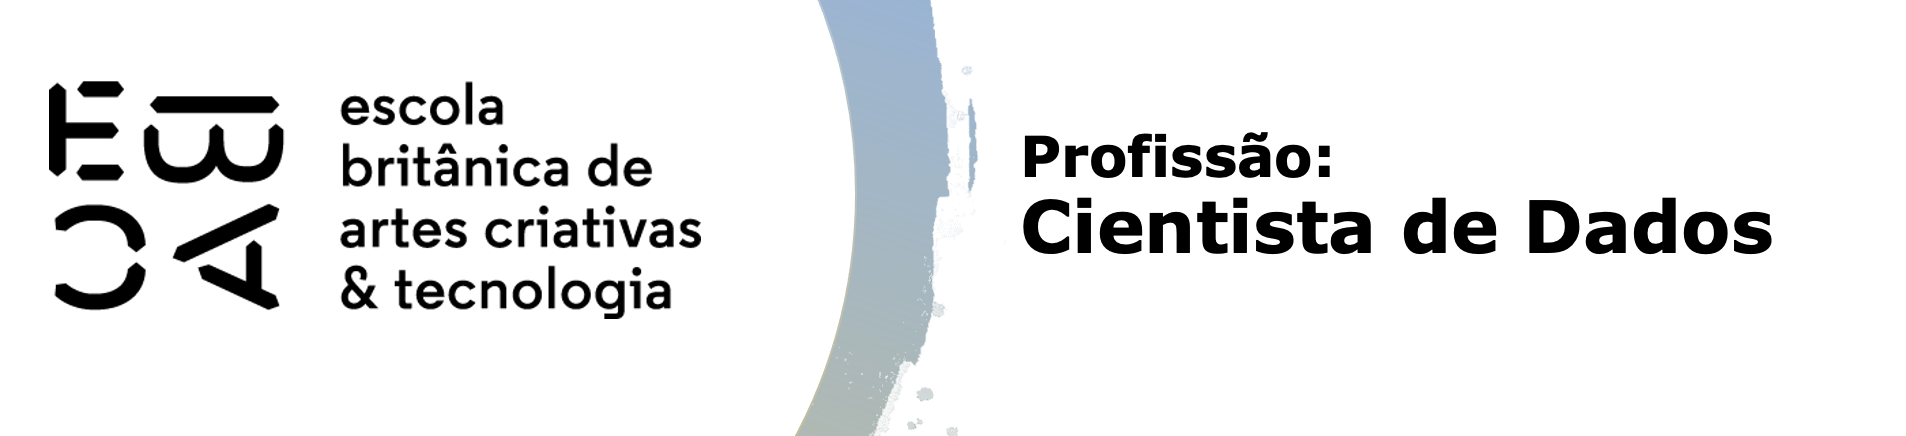

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [20]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.model_selection import train_test_split
from sklearn.tree            import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import ConfusionMatrixDisplay
from sklearn.metrics         import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time

%matplotlib inline

In [21]:
# Carregando as bases lidas na tarefa anterior com seus respectivos índices

# Carregando os dados de treinamento
X_train = pd.read_csv('/content/X_train.csv', index_col=['Unnamed: 0', 'subject_train'])
y_train = (pd.read_csv('/content/y_train.txt', header=None).squeeze('columns'))

# Carregando os dados de teste
X_test = pd.read_csv('/content/X_test.csv', index_col=['Unnamed: 0', 'subject_test'])
y_test = (pd.read_csv('/content/y_test.txt', header=None).squeeze('columns'))

### 2. Calcule os ```ccp_alphas```.

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [22]:
%%time
'''As três variáveis mais importantes são:
53 tGravityAcc-min()-X
390 fBodyAccJerk-bandsEnergy()-1,16
42 tGravityAcc-mean()-Y'''


# Selecionando as 3 melhores variáveis
X_train = X_train[['53 tGravityAcc-min()-X', '390 fBodyAccJerk-bandsEnergy()-1,16', '42 tGravityAcc-mean()-Y']]
X_test = X_test[['53 tGravityAcc-min()-X', '390 fBodyAccJerk-bandsEnergy()-1,16', '42 tGravityAcc-mean()-Y']]

# Criando o classificador de árvore de decisão
clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=20)

# Ajustando o classificador aos dados de treinamento
clf.fit(X_train, y_train)

# Calculando os ccp_alphas
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

print(ccp_alphas)


[0.00000000e+00 6.43815742e-06 6.59906426e-06 8.26772494e-06
 9.85633407e-06 1.04385454e-05 1.07972583e-05 1.18205607e-05
 1.25492253e-05 2.00538489e-05 2.04026115e-05 2.06086985e-05
 2.30817423e-05 2.94533941e-05 3.34812087e-05 3.68012474e-05
 4.68847891e-05 4.71040159e-05 5.07449569e-05 5.87197700e-05
 5.91842553e-05 5.97128157e-05 6.36454967e-05 6.89360965e-05
 6.93966379e-05 7.54278366e-05 7.65465945e-05 7.96357451e-05
 8.02457230e-05 8.09934895e-05 9.28372800e-05 9.74328796e-05
 1.03837119e-04 1.24913948e-04 1.27435359e-04 1.33764496e-04
 1.35961757e-04 1.54565239e-04 1.58686979e-04 1.77825747e-04
 1.98255304e-04 2.05841756e-04 2.12773371e-04 2.16391334e-04
 2.38937546e-04 2.45372701e-04 2.65773702e-04 2.79807244e-04
 2.97474754e-04 3.01505259e-04 3.02829336e-04 3.16912071e-04
 3.16965951e-04 3.25678178e-04 3.27800845e-04 3.33730300e-04
 3.42285571e-04 3.52767845e-04 3.76274354e-04 3.78579953e-04
 4.32101227e-04 4.32428033e-04 4.37044615e-04 4.48996367e-04
 4.97759539e-04 5.067973

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [23]:
%%time


# Definindo o espaço de busca para o parâmetro ccp_alpha
param_grid = {'ccp_alpha': ccp_alphas[::10]}

# Criando o objeto KFold
kf = KFold(n_splits=10)

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0, min_samples_leaf=20), param_grid, cv=kf)

# Medindo o tempo de execução
start_time = time.time()

# Realizando o Grid Search
grid_search.fit(X_train, y_train)

# Imprimindo o tempo de execução
print("Tempo de execução: %s segundos" % (time.time() - start_time))

# Imprimindo os melhores parâmetros encontrados
print("Melhores parâmetros: ", grid_search.best_params_)


Tempo de execução: 2.3321609497070312 segundos
Melhores parâmetros:  {'ccp_alpha': 0.005446468743425373}
CPU times: user 2.3 s, sys: 705 µs, total: 2.3 s
Wall time: 2.33 s


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [24]:
# Obtendo a árvore na melhor configuração treinada em toda a base de treino
best_clf = grid_search.best_estimator_

# Calculando a acurácia dessa árvore na base de testes
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Acurácia: ", accuracy)

# Visualizando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


Acurácia:  0.7207329487614523


### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

#### 5.1. Para melhorar a árvore de decisão:

Criar uma variável binária para uma das classes de maior erro. Por exemplo, se a classe ‘1’ é a que tem mais erros, você pode criar uma nova variável que é ‘1’ quando a classe é ‘1’ e ‘0’ caso contrário.

In [33]:
# Criando uma variável binária para a classe 1
y_train_bin = (y_train == 1).astype(int) # Se a classe é '1', a nova variável será '1'. Caso contrário, será '0'.
y_test_bin = (y_test == 1).astype(int) # Fazendo o mesmo para os dados de teste.

#### 5.2. Criando uma árvore de decisão simples para esta nova variável.

In [34]:
# Criando um classificador de árvore de decisão com profundidade máxima de 4 e pelo menos 20 amostras por folha
clf_bin = DecisionTreeClassifier(random_state=0, min_samples_leaf=20, max_depth=4)

# Ajustando o classificador à nova variável binária
clf_bin.fit(X_train, y_train_bin)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=0)

#### Observar a importância das variáveis e selecionar as 3 com maior importância.

In [35]:
# Obtendo os índices das variáveis ordenadas pela importância
indices = np.argsort(importances)[::-1]

# Obtendo os nomes das variáveis
features = X_train.columns

print("Feature ranking:")

# Imprimindo as 3 variáveis mais importantes
for i in range(3):
    print(f"{i+1}. feature {features[indices[i]]} ({importances[indices[i]]})")


Feature ranking:
1. feature 390 fBodyAccJerk-bandsEnergy()-1,16 (0.6337347230099645)
2. feature 53 tGravityAcc-min()-X (0.350383966664642)
3. feature 42 tGravityAcc-mean()-Y (0.015881310325393416)


#### 5.4. Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia.

In [36]:
# Selecionando as 3 melhores variáveis
X_train_new = X_train[features[indices[:3]]]
X_test_new = X_test[features[indices[:3]]]

# Criando o classificador de árvore de decisão
clf_new = DecisionTreeClassifier(random_state=0, min_samples_leaf=20)

# Ajustando o classificador aos dados de treinamento
clf_new.fit(X_train_new, y_train)

# Calculando a acurácia dessa árvore na base de testes
y_pred_new = clf_new.predict(X_test_new)
accuracy_new = accuracy_score(y_test, y_pred_new)

print("Nova acurácia: ", accuracy_new)


Nova acurácia:  0.673905666779776


> A acurácia inicial do modelo era de 72,07%, indicando que o modelo estava prevendo corretamente o resultado cerca de 72,07% das vezes. Após a adição de novas variáveis e o re-treinamento, a acurácia diminuiu ligeiramente para 67,39%, o que significa que o modelo agora está prevendo corretamente o resultado cerca de 67,39% das vezes. Embora a adição de mais informações ao modelo tenha resultado em uma diminuição da acurácia, isso pode acontecer quando as variáveis adicionadas não contribuem positivamente para a capacidade preditiva do modelo ou quando introduzem ruído no modelo.